# Subject Data Preprocessing WM Prior

#### 1. Load libraries

In [1]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import shutil as sh
import mne
from mne.datasets import eegbci
import shutil
from mne_bids import read_raw_bids, BIDSPath, print_dir_tree
from mne_bids.stats import count_events
import os.path as op
import shutil

import mne
import nibabel as nib
import numpy as np
from nilearn.plotting import plot_anat
import mne_bids
from mne_bids import (
    BIDSPath,
    convert_montage_to_mri,
    convert_montage_to_ras,
    get_anat_landmarks,
    print_dir_tree,
    read_raw_bids,
    search_folder_for_text,
    template_to_head,
    write_anat,
    write_raw_bids,
)

#### 2. Name subject variables

In [2]:
Exp_Modality = 'iEEG'
Exp_ID = 'EXP01'
participant = 's06'
ID ='WAB112023C'
subject_ID =  ID + participant
session_n = '01'
task_n = 'iEEGwmprior'

#### 3. Define necessary paths

In [3]:
sys_dir = os.path.join('/archive','intracranial') 
mne_dir = os.path.join(sys_dir,'Exp_3_WM_prior')  
data_dir = os.path.join(mne_dir , 'Raw')
bids_dir = os.path.join(mne_dir, 'raw_BIDS')
edf_path = sorted(glob.glob(os.path.join(data_dir,participant,'func','*.EDF')))  
ravecsv = os.path.join(sys_dir,'rave_data','data_dir','CLINIC_PATIENTS',ID,'rave','meta','electrodes.csv')

#### 4. Concatenate and correct data

There may be a big gap in between blocks because of something that happened during the trial, here we check the notes and cut and concatenate if necessary.

In [4]:
WAB_NOTUNI = mne.io.read_raw_edf(edf_path[0])
WAB_UNI = mne.io.read_raw_edf(edf_path[1])

Extracting EDF parameters from /archive/intracranial/Exp_3_WM_prior/Raw/s06/func/WAB_NOTUNI.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /archive/intracranial/Exp_3_WM_prior/Raw/s06/func/WAB_UNI.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_4042659/547024576.py:1: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  WAB_NOTUNI = mne.io.read_raw_edf(edf_path[0])
/tmp/ipykernel_4042659/547024576.py:2: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  WAB_UNI = mne.io.read_raw_edf(edf_path[1])


In [5]:
raw = mne.concatenate_raws([WAB_UNI, WAB_NOTUNI]).copy()

In [6]:
"""""""""
WMNOTUNI1 = mne.io.read_raw_edf(edf_path[0]).crop(200,  1600).copy()
WMNOTUNI2 = mne.io.read_raw_edf(edf_path[0]).crop(1890,  3200).copy()
WMNOTUNI = mne.concatenate_raws([WMNOTUNI1, WMNOTUNI2]).copy()
WMUNI = mne.io.read_raw_edf(edf_path[1])
raw = mne.concatenate_raws([WMUNI, WMNOTUNI]).copy()
"""""""""

'\nWMNOTUNI1 = mne.io.read_raw_edf(edf_path[0]).crop(200,  1600).copy()\nWMNOTUNI2 = mne.io.read_raw_edf(edf_path[0]).crop(1890,  3200).copy()\nWMNOTUNI = mne.concatenate_raws([WMNOTUNI1, WMNOTUNI2]).copy()\nWMUNI = mne.io.read_raw_edf(edf_path[1])\nraw = mne.concatenate_raws([WMUNI, WMNOTUNI]).copy()\n'

#### 5. Load CSV with RAVE data and keep only important channels in raw

In [7]:
electrodes = pd.read_csv(ravecsv)
electrodes["Label"] = electrodes["Label"].str.replace("R", "", regex=False)
electrodes["Label"] = electrodes["Label"].str.replace("Lesio", "L", regex=False)
print("Electrodes:", electrodes.head())

Electrodes:    Electrode    Coord_x    Coord_y   Coord_z Label LabelPrefix  Dimension  \
0          1  11.824319 -71.421478  5.215819  MPL1        MPLR         12   
1          2  12.291244 -73.822663  4.312205  MPL2        MPLR         12   
2          3  12.850257 -77.073955  3.303494  MPL3        MPLR         12   
3          4  13.432117 -81.024597  2.389459  MPL4        MPLR         12   
4          5  13.974637 -83.937799  1.715762  MPL5        MPLR         12   

   Interpolation LocationType  Radius  ... Sphere_z        T1R        T1A  \
0             10         iEEG       1  ...        0  12.160348 -48.487113   
1             10         iEEG       1  ...        0  12.627273 -50.888299   
2             10         iEEG       1  ...        0  13.186286 -54.139591   
3             10         iEEG       1  ...        0  13.768146 -58.090232   
4             10         iEEG       1  ...        0  14.310666 -61.003435   

         T1S   MNI152_x    MNI152_y  MNI152_z MRVoxel_I MRVoxe

In [9]:
electrode_labels = electrodes['Label'].tolist()
raw_channel_names = raw.ch_names
channels_to_keep = [channel for channel in raw_channel_names if channel in electrode_labels]
if 'TRIG' in raw_channel_names:
    channels_to_keep.append('TRIG')
raw.pick_channels(channels_to_keep)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | WAB_UNI.EDF, 151 x 10092032 (4927.8 s), ~119 KiB, data not loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 1.000 (s)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:   22.0s remaining:   33.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:   33.3s remaining:   14.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   43.9s finished


Plotting power spectral density (dB=True).


/tmp/ipykernel_4042659/3594698232.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mne.viz.plot_raw_psd(raw,fmax = 100, n_jobs = 10)
/home/intracranial/fsl/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


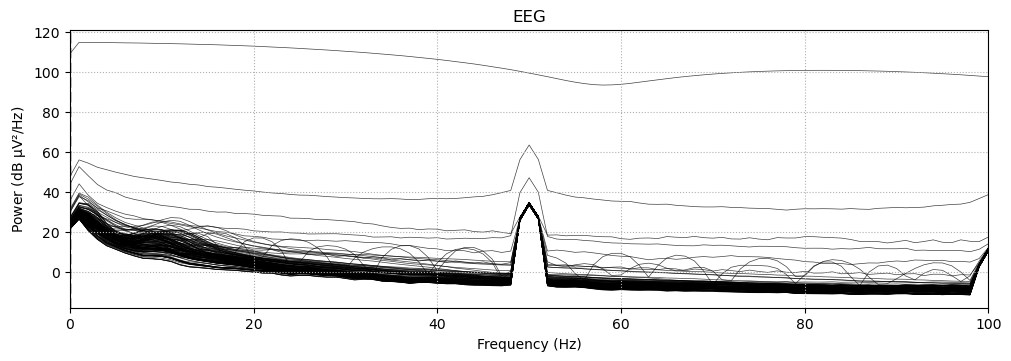

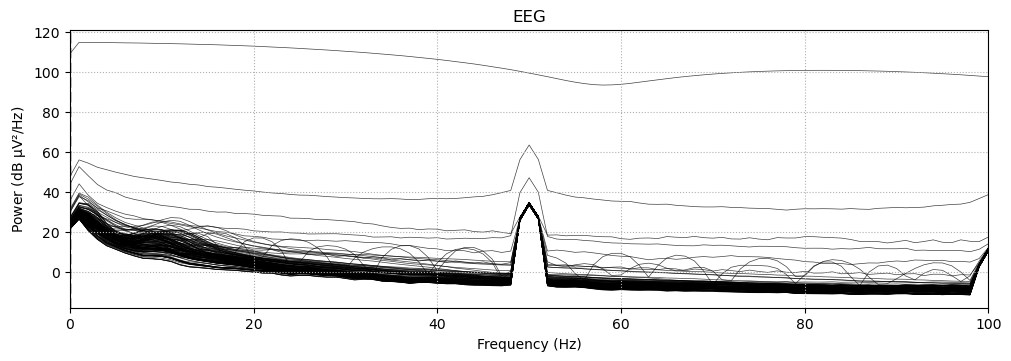

In [10]:
mne.viz.plot_raw_psd(raw,fmax = 100, n_jobs = 10)

#### 6. Find and plot events

In [11]:
events = mne.find_events(raw, stim_channel= "TRIG", output='onset')

Trigger channel TRIG has a non-zero initial value of 250 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1812 events found on stim channel TRIG
Event IDs: [ 7 39 49 97]


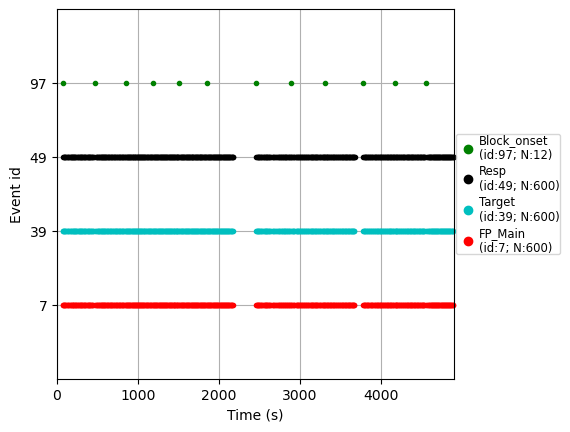

In [12]:
event_id = {'Block_onset': 97, 'FP_Main': 7, 'Target': 39,'Resp': 49}
color = {97: 'green', 7: 'red', 39: 'c', 49: 'black'}

mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, color=color,
                    event_id=event_id);

#### 7. Save events annotations in dataset

In [14]:
reversed_event_id = {v: k for k, v in event_id.items()}

descriptions = []
for event_code in events[:, 2]:
    if event_code in reversed_event_id:
        descriptions.append(reversed_event_id[event_code])
    else:
        print(f"Event code {event_code} not found in event_id. Using 'Unknown'.")
        descriptions.append("Unknown")

In [15]:
raw_annotated = raw.copy()

event_codes = [event_id[event] for event in event_id]
event_descriptions = [event for event in event_id]

descriptions = []
for event_code in events[:, 2]:
    if event_code in event_codes:
        descriptions.append(event_descriptions[event_codes.index(event_code)])
    else:
        print(f"Event code {event_code} not found in event_id. Using 'Unknown'.")
        descriptions.append("Unknown")

annotations = mne.Annotations(onset=events[:, 0] / raw.info['sfreq'],
                              duration=[0] * len(events),
                              description=descriptions)
raw_annotated.set_annotations(annotations)

<RawEDF | WAB_UNI.EDF, 151 x 10092032 (4927.8 s), ~119 KiB, data not loaded>

#### 8. Convert to BIDS

In [16]:
#Save raw_annotated to fif to avoid issues posteriori
fif_path = os.path.join(mne_dir, 'Raw', participant, f'{participant}_annotated_raw.fif')
raw_annotated.save(fif_path, overwrite=True)

Overwriting existing file.
Writing /archive/intracranial/Exp_3_WM_prior/Raw/s06/s06_annotated_raw.fif
Closing /archive/intracranial/Exp_3_WM_prior/Raw/s06/s06_annotated_raw.fif
Overwriting existing file.
Writing /archive/intracranial/Exp_3_WM_prior/Raw/s06/s06_annotated_raw-1.fif
Closing /archive/intracranial/Exp_3_WM_prior/Raw/s06/s06_annotated_raw-1.fif
Writing /archive/intracranial/Exp_3_WM_prior/Raw/s06/s06_annotated_raw-2.fif
Closing /archive/intracranial/Exp_3_WM_prior/Raw/s06/s06_annotated_raw-2.fif
[done]


[PosixPath('/archive/intracranial/Exp_3_WM_prior/Raw/s06/s06_annotated_raw.fif'),
 PosixPath('/archive/intracranial/Exp_3_WM_prior/Raw/s06/s06_annotated_raw-1.fif'),
 PosixPath('/archive/intracranial/Exp_3_WM_prior/Raw/s06/s06_annotated_raw-2.fif')]

In [17]:
#get channels
channel_mapping = {ch_name: "seeg" for ch_name in raw_annotated.ch_names if ch_name != "TRIG"}
channel_mapping["TRIG"] = "stim"
raw_annotated.set_channel_types(mapping=channel_mapping)

bids_path = mne_bids.BIDSPath(subject=participant, session=session_n, task=task_n, root=bids_dir, datatype='ieeg') #define BIDS path

#conversion of the electrodes to a dictionary compatible with mne
ch_pos = {
    row['Label']: np.array([row['Coord_x'], row['Coord_y'], row['Coord_z']])
    for _, row in electrodes.iterrows()
}

#define the montage, since the T1 was manually aligned with ACPC and the electrode localization was done in that space
#i later skiped the head → MRI transformation and MRI → RAS transformation.
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='mri')
raw_annotated.set_montage(montage, on_missing="ignore") #ignore is for the TRIG channel, because is not in electrodes.csv but it is still important

#load data and write it to bids using the montage defined earlier
raw_annotated.load_data()
mne_bids.write_raw_bids(raw_annotated, bids_path, events=events, event_id=event_id,
                         overwrite=True, allow_preload=True, format='BrainVision',
                         montage=montage, acpc_aligned=True) #True since it has been previously aligned

#save electrode data 
electrodes.to_csv(bids_path.copy().update(suffix='channels', extension='.tsv'), sep='\t', index=False)

#ensure 'participants.tsv' exists
participants_file = os.path.join(bids_dir, 'participants.tsv')
if not os.path.exists(participants_file):
    participants_df = pd.DataFrame({'participant_id': [participant]})
    participants_df.to_csv(participants_file, sep='\t', index=False)

#save anatomical images

t1_path = os.path.join(sys_dir, 'rave_data', 'data_dir', 'CLINIC_PATIENTS', ID, 'MRI', 't1_acpc_s06_defaced.nii')
t1_bids_path = mne_bids.BIDSPath(subject=participant, session=session_n, root=bids_dir, suffix="T1w")

mne_bids.write_anat(image=t1_path, bids_path=t1_bids_path, deface=False, overwrite=True, verbose=True)

ct_path = os.path.join(sys_dir, 'rave_data', 'data_dir', 'CLINIC_PATIENTS', ID, 'CT', 'CT.nii')
ct_bids_path = mne_bids.BIDSPath(subject=participant, session=session_n, root=bids_dir, suffix="FLASH")

mne_bids.write_anat(image=ct_path, bids_path=ct_bids_path, overwrite=True, verbose=True)


Reading 0 ... 10092031  =      0.000 ...  4927.750 secs...


/tmp/ipykernel_4042659/1973340287.py:17: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_annotated.set_montage(montage, on_missing="ignore") #ignore is for the TRIG channel, because is not in electrodes.csv but it is still important


Writing '/archive/intracranial/Exp_3_WM_prior/raw_BIDS/participants.tsv'...
Writing '/archive/intracranial/Exp_3_WM_prior/raw_BIDS/participants.json'...


/tmp/ipykernel_4042659/1973340287.py:21: RuntimeWarning: Coordinate frame could not be inferred from the raw object and the BIDSPath.space was none, skipping the writing of channel positions
  mne_bids.write_raw_bids(raw_annotated, bids_path, events=events, event_id=event_id,


Used Annotations descriptions: ['Block_onset', 'FP_Main', 'Resp', 'Target']
Writing '/archive/intracranial/Exp_3_WM_prior/raw_BIDS/sub-s06/ses-01/ieeg/sub-s06_ses-01_task-iEEGwmprior_events.tsv'...
Writing '/archive/intracranial/Exp_3_WM_prior/raw_BIDS/sub-s06/ses-01/ieeg/sub-s06_ses-01_task-iEEGwmprior_events.json'...
Writing '/archive/intracranial/Exp_3_WM_prior/raw_BIDS/dataset_description.json'...
Writing '/archive/intracranial/Exp_3_WM_prior/raw_BIDS/sub-s06/ses-01/ieeg/sub-s06_ses-01_task-iEEGwmprior_ieeg.json'...
Writing '/archive/intracranial/Exp_3_WM_prior/raw_BIDS/sub-s06/ses-01/ieeg/sub-s06_ses-01_task-iEEGwmprior_channels.tsv'...
Copying data files to sub-s06_ses-01_task-iEEGwmprior_ieeg.vhdr


/tmp/ipykernel_4042659/1973340287.py:21: RuntimeWarning: Converting data files to BrainVision format
  mne_bids.write_raw_bids(raw_annotated, bids_path, events=events, event_id=event_id,
/tmp/ipykernel_4042659/1973340287.py:21: RuntimeWarning: Encountered data in "int" format. Converting to float32.
  mne_bids.write_raw_bids(raw_annotated, bids_path, events=events, event_id=event_id,


Writing '/archive/intracranial/Exp_3_WM_prior/raw_BIDS/sub-s06/ses-01/sub-s06_ses-01_scans.tsv'...
Wrote /archive/intracranial/Exp_3_WM_prior/raw_BIDS/sub-s06/ses-01/sub-s06_ses-01_scans.tsv entry with ieeg/sub-s06_ses-01_task-iEEGwmprior_ieeg.vhdr.


BIDSPath(
root: /archive/intracranial/Exp_3_WM_prior/raw_BIDS
datatype: anat
basename: sub-s06_ses-01_FLASH.nii.gz)